# Hedging Analysis of FX Options

Here I analyse the hedging performance of Black-Scholes and SABR models on FX options.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator
from scipy.stats import norm
import ast  # For safely evaluating strings as arrays
from Helper_Functions import *

# Configuration
pd.options.mode.chained_assignment = None

# Load data
full = pd.read_csv('cleaned_fx_vol_data.csv').sort_values(by=['cur', 'date', 'tenor', 'delta'], ascending=[True, True, True, False])
matrix = pd.read_csv('sabr_parameters.csv')

# Convert string representations of arrays to actual arrays
def safe_convert_array(x):
    try:
        return ast.literal_eval(x) if isinstance(x, str) else x
    except:
        return np.nan

array_cols = ['strikes', 'vols']
for col in array_cols:
    if col in matrix.columns:
        matrix[col] = matrix[col].apply(safe_convert_array)

## Merge SABR Parameters matrix with cleaned vol data

In [2]:
def get_sabr_params(row):
    match = matrix[
        (matrix['currency'] == row['cur']) & 
        (matrix['date'] == row['date']) & 
        (matrix['tenor'] == row['tenor'])
    ]
    if not match.empty:
        row['fwd'] = match.iloc[0]['fwd']
        match['strike'] = get_strike(row)
        return match.iloc[0][['alpha', 'rho', 'nu', 'fwd', 'strike']]
    return pd.Series([np.nan]*4, index=['alpha', 'rho', 'nu', 'fwd', 'strike'])

full[['alpha', 'rho', 'nu', 'fwd', 'strike']] = full.apply(get_sabr_params, axis=1)

In [3]:
full.head()

,cur,tenor,vol,spot,date,delta,alpha,rho,nu,fwd,strike
6,AUDCAD,0.25,0.0882,0.905,12,0.95,0.065965,-0.221786,1.128806,0.9045,0.842031
5,AUDCAD,0.25,0.0818,0.905,12,0.90,0.065965,-0.221786,1.128806,0.9045,0.859029
4,AUDCAD,0.25,0.0746,0.905,12,0.75,0.065965,-0.221786,1.128806,0.9045,0.882642
3,AUDCAD,0.25,0.0690,0.905,12,0.50,0.065965,-0.221786,1.128806,0.9045,0.905038
2,AUDCAD,0.25,0.0678,0.905,12,0.25,0.065965,-0.221786,1.128806,0.9045,0.925952


## Hedging Calculations

We calculate Black-Scholes and SABR greeks and prices, and prepare splines for staggered (previous day) analysis.

In [4]:
# Initialize storage for results
results = {
    'bs_vega': [],
    'bs_price': [],
    'sabr_delta': [],
    'sabr_vega': [],
    'vol_spline': [],
    'price_spline': [],
    'stag_vol_spline': [],
    'stag_price_spline': [],
    'stag_fwd': [],
    'stag_alpha': [],
    'stag_strikes': []
}

# Get sorted unique dates for staggered calculations
dates = sorted(full['date'].unique())

# Group by currency and date for efficient processing
grouped = full.groupby(['cur', 'date', 'tenor'])

for (currency, date, tenor), smile in grouped:
    try:
        if smile.empty:
            continue
        
        # Calculate BS metrics and SABR greeks for each option in the smile
        bs_prices = []
        for _, row in smile.iterrows():
            bs = BlackScholes(
                S=row['spot'], 
                f=row['fwd'], 
                K=row['strike'], 
                T=row['tenor'], 
                sigma=row['vol']
            )
            bs_price, bs_vega = bs.price(), bs.vega()
            bs_prices.append(bs_price)
            results['bs_price'].append(bs_price)
            results['bs_vega'].append(bs_vega)
            
            sabr = SABR(
                alpha=row['alpha'], 
                beta=0.75, 
                rho=row['rho'], 
                nu=row['nu'],
                bs_delta=row['delta'], 
                bs_vega=bs_vega,
                f=row['fwd'], 
                K=row['strike'], 
                T=row['tenor']
            )
            results['sabr_delta'].append(sabr.delta())
            results['sabr_vega'].append(sabr.vega())
        
        strikes = smile['strike'].values
        vols = smile['vol'].values

        vol_spline = PchipInterpolator(strikes, vols)
        price_spline = PchipInterpolator(strikes, bs_prices)
        
        n_options = len(smile)
        results['vol_spline'].extend([vol_spline] * n_options)
        results['price_spline'].extend([price_spline] * n_options)
        
        # Staggered calculations (previous day's data)
        date_idx = dates.index(date)
        if date_idx > 0:  # Not the first date
            prev_date = dates[date_idx - 1]
            prev_smile = full[
                (full['cur'] == currency) & 
                (full['date'] == prev_date) & 
                (full['tenor'] == tenor)
            ]
            
            if not prev_smile.empty:
                prev_strikes = prev_smile['strike'].values
                prev_vols = prev_smile['vol'].values
                prev_prices = [
                    BlackScholes(
                        S=row['spot'], 
                        f=row['fwd'], 
                        K=row['strike'], 
                        T=row['tenor'], 
                        sigma=row['vol']
                    ).price() 
                    for _, row in prev_smile.iterrows()
                ]
                
                results['stag_vol_spline'].extend(
                    [PchipInterpolator(prev_strikes, prev_vols)] * n_options
                )
                results['stag_price_spline'].extend(
                    [PchipInterpolator(prev_strikes, prev_prices)] * n_options
                )
                results['stag_fwd'].extend([prev_smile['fwd'].iloc[0]] * n_options)
                results['stag_alpha'].extend([prev_smile['alpha'].iloc[0]] * n_options)
                results['stag_strikes'].extend(prev_strikes)
                continue
        
        # If no previous data exists, fill with NaN
        for key in ['stag_vol_spline', 'stag_price_spline', 'stag_fwd', 'stag_alpha', 'stag_strikes']:
            results[key].extend([np.nan] * n_options)
    except:
        for key in results.keys():
            results[key].extend([np.nan] * len(smile))

        print(f"Error processing currency: {currency}, date: {date}, tenor: {tenor}")
        continue

# Add calculated columns to dataframe
full['bs_vega'] = results['bs_vega']
full['bs_price'] = results['bs_price']
full['sabr_delta'] = results['sabr_delta']
full['sabr_vega'] = results['sabr_vega']

In [5]:
# Calculate staggered differences using results dict
full['d_alpha'] = pd.Series(results['stag_alpha'], index=full.index) - full['alpha']
full['d_fwd'] = pd.Series(results['stag_fwd'], index=full.index) - full['fwd']

# Calculate staggered price and vol changes
price_changes, vol_changes = [], []
for i in range(len(full)):
    try:
        # Only call if not nan
        if not pd.isna(results['stag_price_spline'][i]):
            price_changes.append(results['stag_price_spline'][i](full['strike'].iloc[i]) - full['bs_price'].iloc[i])
        else:
            price_changes.append(np.nan)
        if not pd.isna(results['stag_vol_spline'][i]):
            vol_changes.append(results['stag_vol_spline'][i](full['strike'].iloc[i]) - full['vol'].iloc[i])
        else:
            vol_changes.append(np.nan)
    except Exception:
        price_changes.append(np.nan)
        vol_changes.append(np.nan)

full['real_price_change'] = price_changes
full['d_vol'] = vol_changes

# Calculate predictions and errors
full['bs_pred_delta'] = full['delta'] * full['d_fwd']
full['sabr_pred_delta'] = full['sabr_delta'] * full['d_fwd']

full['bs_pred_deltavega'] = full['bs_pred_delta'] + full['bs_vega'] * full['d_vol']
full['sabr_pred_deltavega'] = full['sabr_pred_delta'] + full['sabr_vega'] * full['d_alpha']

full['bs_error'] = abs(full['bs_pred_deltavega'] - full['real_price_change'])
full['sabr_error'] = abs(full['sabr_pred_deltavega'] - full['real_price_change'])

In [6]:
full[full['date']==13].head()

,cur,tenor,vol,spot,date,delta,alpha,rho,nu,fwd,...,d_alpha,d_fwd,real_price_change,d_vol,bs_pred_delta,sabr_pred_delta,bs_pred_deltavega,sabr_pred_deltavega,bs_error,sabr_error
48,AUDCAD,0.25,0.0880,0.91,13,0.95,0.065481,-0.224091,1.144862,0.909497,...,0.000484,-0.004997,-0.004880,-0.001713,-0.004747,-0.004830,-0.004828,-0.004807,0.000052,0.000072
47,AUDCAD,0.25,0.0815,0.91,13,0.90,0.065481,-0.224091,1.144862,0.909497,...,0.000484,-0.004997,-0.004556,-0.001325,-0.004498,-0.004630,-0.004603,-0.004591,0.000047,0.000035
46,AUDCAD,0.25,0.0741,0.91,13,0.75,0.065481,-0.224091,1.144862,0.909497,...,0.000484,-0.004997,-0.003763,-0.000966,-0.003748,-0.003939,-0.003888,-0.003867,0.000125,0.000104
45,AUDCAD,0.25,0.0685,0.91,13,0.50,0.065481,-0.224091,1.144862,0.909497,...,0.000484,-0.004997,-0.002321,0.000059,-0.002499,-0.002618,-0.002488,-0.002525,0.000166,0.000204
44,AUDCAD,0.25,0.0671,0.91,13,0.25,0.065481,-0.224091,1.144862,0.909497,...,0.000484,-0.004997,-0.000991,0.000844,-0.001249,-0.001223,-0.001127,-0.001152,0.000136,0.000161


## Visualization and Results

In [7]:
# Correlation Matrix
errors = full[['real_price_change', 'bs_pred_deltavega', 'sabr_pred_deltavega']].dropna()
print("Correlation Matrix:")
print(errors.corr())

Correlation Matrix:
                     real_price_change  bs_pred_deltavega  sabr_pred_deltavega
real_price_change             1.000000           0.993661             0.993277
bs_pred_deltavega             0.993661           1.000000             0.999790
sabr_pred_deltavega           0.993277           0.999790             1.000000


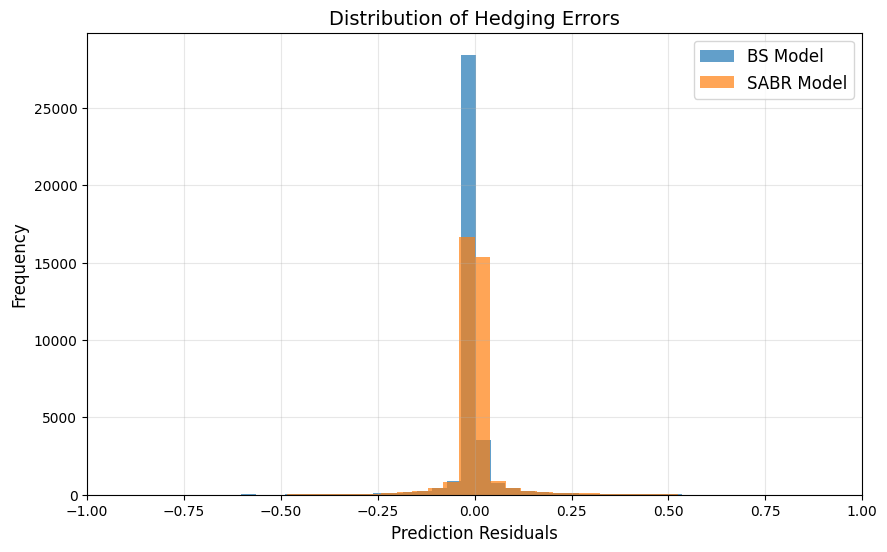

In [8]:
# Residuals Histogram Comparison
plt.figure(figsize=(10, 6))
plt.hist(full['bs_pred_deltavega'] - full['real_price_change'], 
         bins=100, alpha=0.7, label='BS Model')
plt.hist(full['sabr_pred_deltavega'] - full['real_price_change'], 
         bins=100, alpha=0.7, label='SABR Model')
plt.xlabel('Prediction Residuals', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Hedging Errors', fontsize=14)
plt.xlim(-1, 1)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

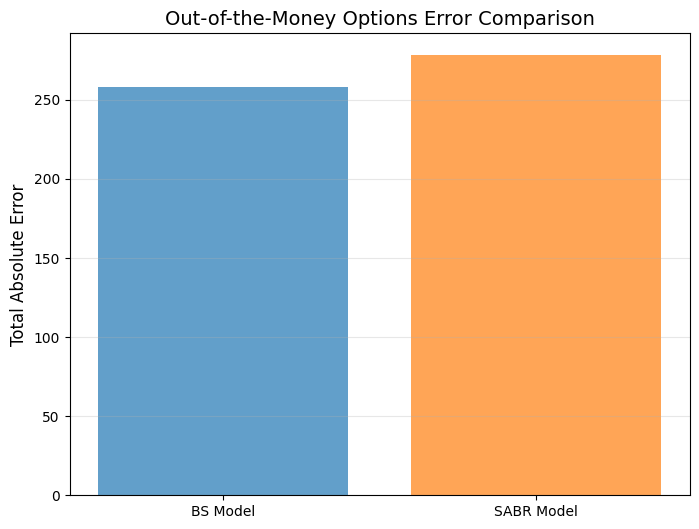

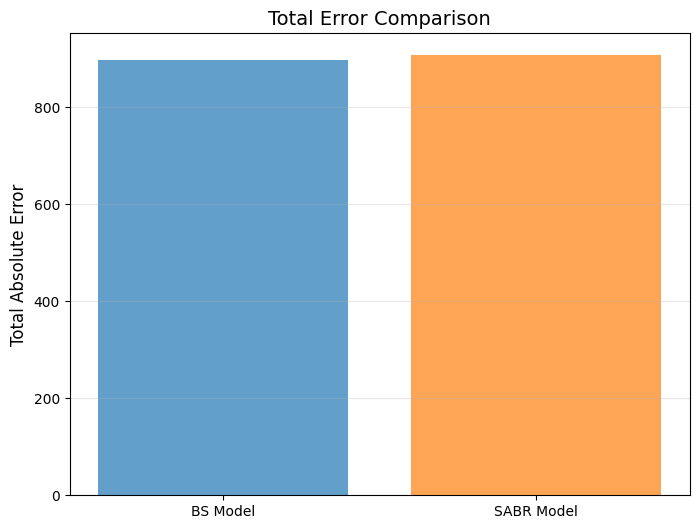

In [9]:
# Error Comparisons
def plot_error_comparison(df, title):
    bs_error = np.sum(df['bs_error'])
    sabr_error = np.sum(df['sabr_error'])
    
    plt.figure(figsize=(8, 6))
    color = ["#1f77b4", "#ff7f0e"]
    plt.bar(['BS Model', 'SABR Model'], [bs_error, sabr_error], alpha=0.7, color=color)
    
    plt.title(title, fontsize=14)
    plt.ylabel('Total Absolute Error', fontsize=12)
    
    plt.grid(axis='y', alpha=0.3)
    plt.show()

plot_error_comparison(full[full['delta'] < 0.5], 'Out-of-the-Money Options Error Comparison')
plot_error_comparison(full, 'Total Error Comparison')

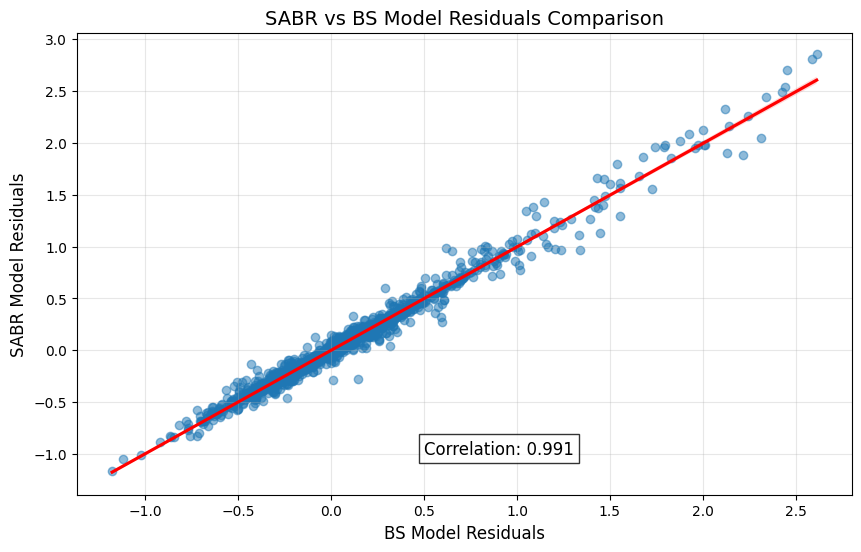

In [10]:
# Residuals Analysis
full['bs_residuals'] = full['real_price_change'] - full['bs_pred_deltavega']
full['sabr_residuals'] = full['real_price_change'] - full['sabr_pred_deltavega']
full['bold_bs'] = full['d_vol']*full['bs_vega']
full['bold_sabr'] = ((full['sabr_delta'] - full['delta'])*full['d_fwd'] + full['d_alpha']*full['sabr_vega'])

# Prepare residuals dataframe
residues = full[['real_price_change', 'bs_residuals', 'sabr_residuals', 
                 'bold_bs', 'bold_sabr']].dropna().astype(float)

import seaborn as sns
# Residuals Scatter Plot
plt.figure(figsize=(10, 6))
sns.regplot(data=residues, x='bs_residuals', y='sabr_residuals',
            scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.xlabel('BS Model Residuals', fontsize=12)
plt.ylabel('SABR Model Residuals', fontsize=12)
plt.text(0.5, -1, f'Correlation: {residues["bs_residuals"].corr(residues["sabr_residuals"]):.3f}', 
         fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
plt.title('SABR vs BS Model Residuals Comparison', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

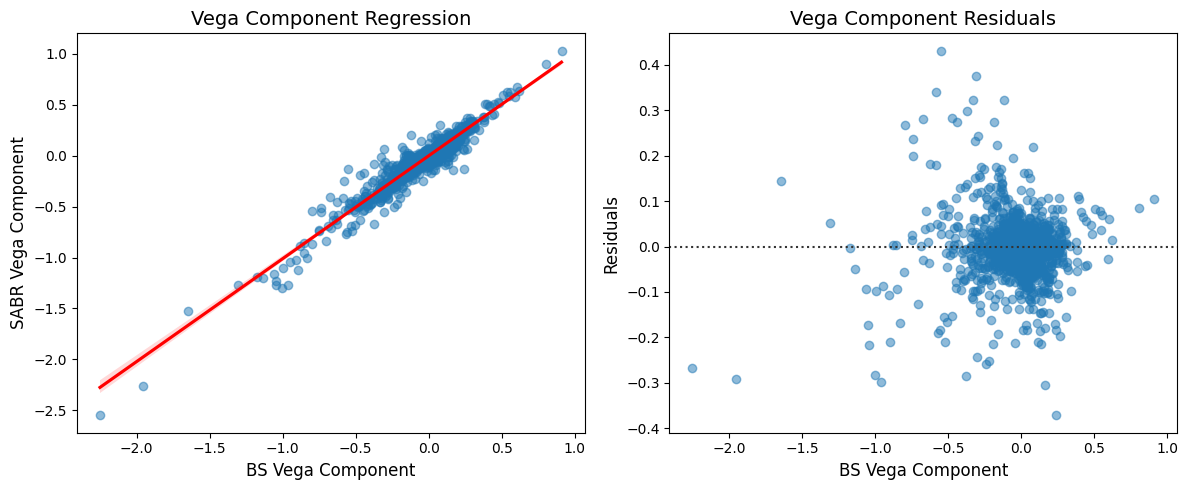

T-test between BS and SABR residuals:
T-statistic: -0.464, p-value: 6.427e-01


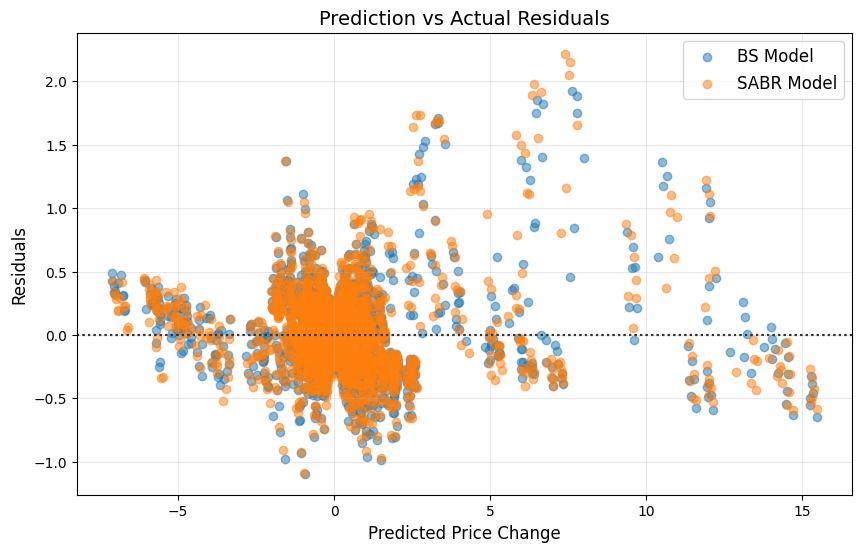

In [11]:
# Vega Component Analysis
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.regplot(data=residues, x='bold_bs', y='bold_sabr',
            scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Vega Component Regression', fontsize=14)
plt.xlabel('BS Vega Component', fontsize=12)
plt.ylabel('SABR Vega Component', fontsize=12)

plt.subplot(1, 2, 2)
sns.residplot(data=residues, x='bold_bs', y='bold_sabr',
              scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Vega Component Residuals', fontsize=14)
plt.xlabel('BS Vega Component', fontsize=12)
plt.ylabel('Residuals', fontsize=12)

plt.tight_layout()
plt.show()

# Statistical Test
from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(residues['bs_residuals'], residues['sabr_residuals'])
print(f"T-test between BS and SABR residuals:\nT-statistic: {t_stat:.3f}, p-value: {p_value:.3e}")

# Prediction vs Actual Residuals
plt.figure(figsize=(10, 6))
sns.residplot(data=full[['bs_pred_deltavega', 'real_price_change']].astype(float),
              x='bs_pred_deltavega', y='real_price_change',
              label='BS Model', scatter_kws={'alpha':0.5})
sns.residplot(data=full[['sabr_pred_deltavega', 'real_price_change']].astype(float),
              x='sabr_pred_deltavega', y='real_price_change',
              label='SABR Model', scatter_kws={'alpha':0.5})
plt.xlabel('Predicted Price Change', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Prediction vs Actual Residuals', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()